In [1]:
import numpy as np
from os.path import expanduser
import os
import json
import theano
import pyret.filtertools as ft
import pyret.visualizations as pyviz
#import deepretina.visualizations as viz
import preprocessing
from preprocessing import datagen, loadexpt
from utils import rolling_window
from keras.models import model_from_json
import h5py
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
#%matplotlib qt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GT 750M (CNMeM is disabled)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
f = h5py.File(os.path.join(preprocessing.datadirs['lane.local'], '15-10-07/whitenoise.h5'), 'r')

In [3]:
time = np.array(f['train/time'])

In [4]:
list(f)

[u'spikes', u'test', u'train']

In [18]:
list(f['train'])

[u'response', u'stimulus', u'time']

In [19]:
list(f['test'])

[u'response', u'stimulus', u'time']

In [16]:
list(f['train/stimulus'].shape)

[359802, 50, 50]

In [37]:
list(f['train/response'])

[u'binned', u'firing_rate_10ms', u'firing_rate_20ms', u'firing_rate_5ms']

In [34]:
f['train/response/firing_rate_10ms'].shape

(9, 359802)

In [25]:
list(f['spikes'])

[u'cell01',
 u'cell02',
 u'cell03',
 u'cell04',
 u'cell05',
 u'cell06',
 u'cell07',
 u'cell08',
 u'cell09']

In [8]:
ncells = 9

In [44]:
h.close()

Cutting out stimulus for cell01
Cutting out stimulus for cell02
Cutting out stimulus for cell03
Cutting out stimulus for cell04
Cutting out stimulus for cell05
Cutting out stimulus for cell06
Cutting out stimulus for cell07
Cutting out stimulus for cell08
Cutting out stimulus for cell09


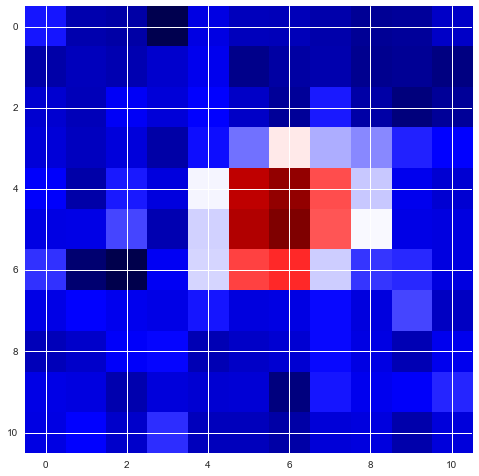

In [46]:
for n in range(ncells):
    print 'Cutting out stimulus for cell%02d' %(n+1)
    spk = f['spikes/cell%02d' %(n+1)]
    sta, tax = ft.getsta(f['train/time'], f['train/stimulus'], spk, 40)
    space, time = ft.decompose(ft.cutout(sta, idx=np.flipud(ft.filterpeak(sta)[1]), width=5))
    plt.imshow(space, cmap='seismic')
    plt.savefig(os.path.join(preprocessing.datadirs['lane.local'], 'STA Cutout of Cell %02d.png' %(n+1)))
    
    new_filename = 'whitenoise_cutout_cell%02d.h5' %(n+1)
    h = h5py.File(os.path.join(preprocessing.datadirs['lane.local'], new_filename), 'w')
    # keep most of the datasets the same
    for idx in range(ncells):
        h.create_dataset('spikes/cell%02d' %(idx+1), data=f['spikes/cell%02d' %(idx+1)])
    h.create_dataset('train/response/binned', data=f['train/response/binned'])
    h.create_dataset('train/response/firing_rate_10ms', data=f['train/response/firing_rate_10ms'])
    h.create_dataset('train/response/firing_rate_20ms', data=f['train/response/firing_rate_20ms'])
    h.create_dataset('train/response/firing_rate_5ms', data=f['train/response/firing_rate_5ms'])
    h.create_dataset('train/time', data=f['train/time'])
    h.create_dataset('test/response/binned', data=f['test/response/binned'])
    h.create_dataset('test/response/firing_rate_10ms', data=f['test/response/firing_rate_10ms'])
    h.create_dataset('test/response/firing_rate_20ms', data=f['test/response/firing_rate_20ms'])
    h.create_dataset('test/response/firing_rate_5ms', data=f['test/response/firing_rate_5ms'])
    h.create_dataset('test/time', data=f['test/time'])
    
    # get stimulus cutouts
    Xcut_train = ft.cutout(np.array(f['train/stimulus']), idx=np.flipud(ft.filterpeak(sta)[1]), width=5)
    Xcut_test = ft.cutout(np.array(f['test/stimulus']), idx=np.flipud(ft.filterpeak(sta)[1]), width=5)
    
    # create stimuli datasets
    h.create_dataset('train/stimulus', data=Xcut_train)
    h.create_dataset('test/stimulus', data=Xcut_test)
    
    h.close()